## Loading of Steinmetz data

includes some visualizations

In [176]:
%%script echo skipping
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA

skipping


In [177]:
import tqdm as tqdm

In [178]:
# @title Figure settings
%%script echo skipping
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

skipping


In [179]:
# @title Data retrieval
%%script echo skipping
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

skipping


In [180]:
# @title Data loading
%%script echo skipping
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

skipping


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

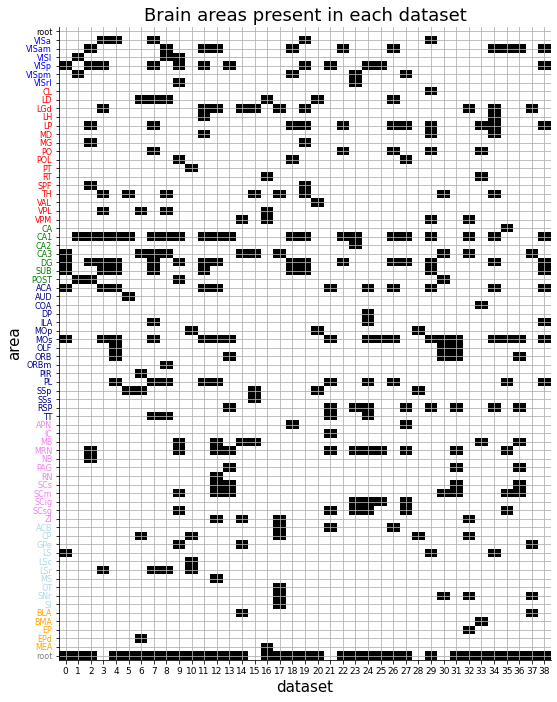

In [181]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"],  # cortical subplate
                ["root"]
                ]
colors_area={"blue":"visual cortex", "red":"thalamus", "green":"hippocampal","darkblue":"non-visual cortex","violet":"midbrain","lightblue":"basal ganglia","orange":"cortical subplate","gray":"root"}

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1


# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

In [182]:
dat = alldat[0]




In [183]:
# for more variables check out the additional notebook (load_steinmetz_extra) which includes LFP, waveform shapes and exact spike times (non-binned)

In [184]:
#dat['ccf']: Allen Institute brain atlas coordinates for each neuron.
#dat['ccf_axes']: axes names for the Allen CCF.

In [185]:
len(dat["ccf"])

734

In [186]:
print(len(alldat[0]["ccf"]))
print(len(alldat[1]["ccf"]))
print(len(alldat[2]["ccf"]))

734
1070
619


In [187]:
print(len(alldat[0]["ccf_axes"]))
print(len(alldat[1]["ccf_axes"]))
print(len(alldat[2]["ccf_axes"]))

3
3
3


In [188]:
alldat[0]["ccf"]

array([[4090. , 2445.4, 5012.4],
       [3952.4, 1516. , 5045.5],
       [4172.1, 2979.3, 5018.3],
       ...,
       [8940.5, 3978.2, 3000.9],
       [9537.1, 1381.6, 2563.1],
       [8914.4, 4093.6, 3020.9]])

In [189]:
alldat[1]["ccf"]

array([[8260.8, 2672.8, 2175.6],
       [8523.9, 1642.8, 1984.8],
       [7793.1, 4503.8, 2514.8],
       ...,
       [8992.8, 1003.5, 3890.1],
       [9170.6, 2448.5, 3770.4],
       [9008.8, 1122.3, 3883.9]])

In [190]:
def data_org(alldat,session_id = 11, ROI_number = 0): # e.g. ROI_number = 0:"vis ctx", 1:"thal", etc.

  assert 0 <= session_id <= 38, 'session_id is out of range, it should be between 0 and 38'

  brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex, ROI_number = 0
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus, ROI_number = 1
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal, ROI_number = 2
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex, ROI_number = 3
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain, ROI_number = 4
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia, ROI_number = 5
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate, ROI_number = 6
                ]
 
  dat = alldat[session_id]
  
  ROI_nn = []
  nn_per_area = [] # store the number of neurons in each sub area of a "macro area" for indexing
  
  ROI = brain_groups[ROI_number]

  nn_per_area = dict()

  indx_counter = 0
  
  # Extract spikes from ROI:
  for r in ROI:
    roi_nn = dat['spks'][dat['brain_area']==r]
    ROI_nn.append(roi_nn)
    if roi_nn.shape[0] >0:
      indx_counter += roi_nn.shape[0] 
      nn_per_area[r] = indx_counter -1 # subtract one to get correct Python indx
       
      #nn_per_area.append((r,indx_counter)) # store n of neurons in that sub area # use this for list instead of dict
      

  # Return activations from same 'macro' area in the same tensor dimension as well as return   
  return np.concatenate(ROI_nn,axis=0), nn_per_area 

In [191]:
r_data, dict_indx = data_org(alldat, session_id = 1, ROI_number = 0)


In [192]:
%%script echo skipping

import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
for y in alldat:
  for x,z in y["ccf"],y["brain_area"]:

    ax.scatter(x[0],x[1],x[2])
plt.show()

skipping


In [193]:
alpha={}
for y in alldat:
  for x in np.unique(y["brain_area"], axis=0):
    alpha[x]=[]
for y in alldat:
  for x in range(len(y["brain_area"])):
    alpha[y["brain_area"][x]].append(list(y["ccf"][x]))
print(alpha)



{'ACA': [[4090.0, 2445.4, 5012.4], [4172.1, 2979.3, 5018.3], [4069.2, 2267.4, 5063.3], [4092.9, 2425.6, 5060.4], [4042.5, 2129.0, 5018.2], [4036.6, 2089.4, 5019.0], [4112.7, 2583.8, 5025.7], [4117.7, 2603.6, 5041.2], [4110.7, 2544.3, 5058.2], [4122.6, 2623.4, 5056.7], [4063.2, 2227.9, 5064.0], [4135.5, 2722.2, 5039.0], [4098.8, 2465.2, 5059.6], [4116.6, 2583.8, 5057.4], [4076.1, 2326.7, 5046.3], [4135.5, 2722.2, 5039.0], [4141.4, 2761.8, 5038.2], [4084.0, 2405.8, 5013.1], [4095.9, 2484.9, 5011.6], [4076.1, 2326.7, 5046.3], [4054.4, 2208.1, 5016.8], [4111.7, 2564.0, 5041.9], [4082.0, 2366.3, 5045.6], [4084.0, 2405.8, 5013.1], [4083.0, 2386.1, 5029.3], [4090.0, 2445.4, 5012.4], [4095.9, 2484.9, 5011.6], [4092.9, 2425.6, 5060.4], [4036.6, 2089.4, 5019.0], [4092.9, 2425.6, 5060.4], [4136.5, 2742.0, 5022.7], [4082.0, 2366.3, 5045.6], [4099.8, 2484.9, 5043.4], [4107.8, 2564.0, 5010.2], [4084.0, 2405.8, 5013.1], [4095.9, 2484.9, 5011.6], [4066.2, 2287.2, 5015.3], [4131.5, 2722.2, 5007.2], [41

3
2
2
5
3
2
0
7
2
2
0
0
1
1
4
4
1
0
1
5
1
0
1
3
3
3
3
3
5
6
1
3
3
1
3
3
5
4
1
4
4
0
5
3
1
1
1
5
4
4
4
4
3
6
1
3
6
1
5
5
5
5
4
1
4
2
4
3
1
6
6
3
2


No handles with labels found to put in legend.


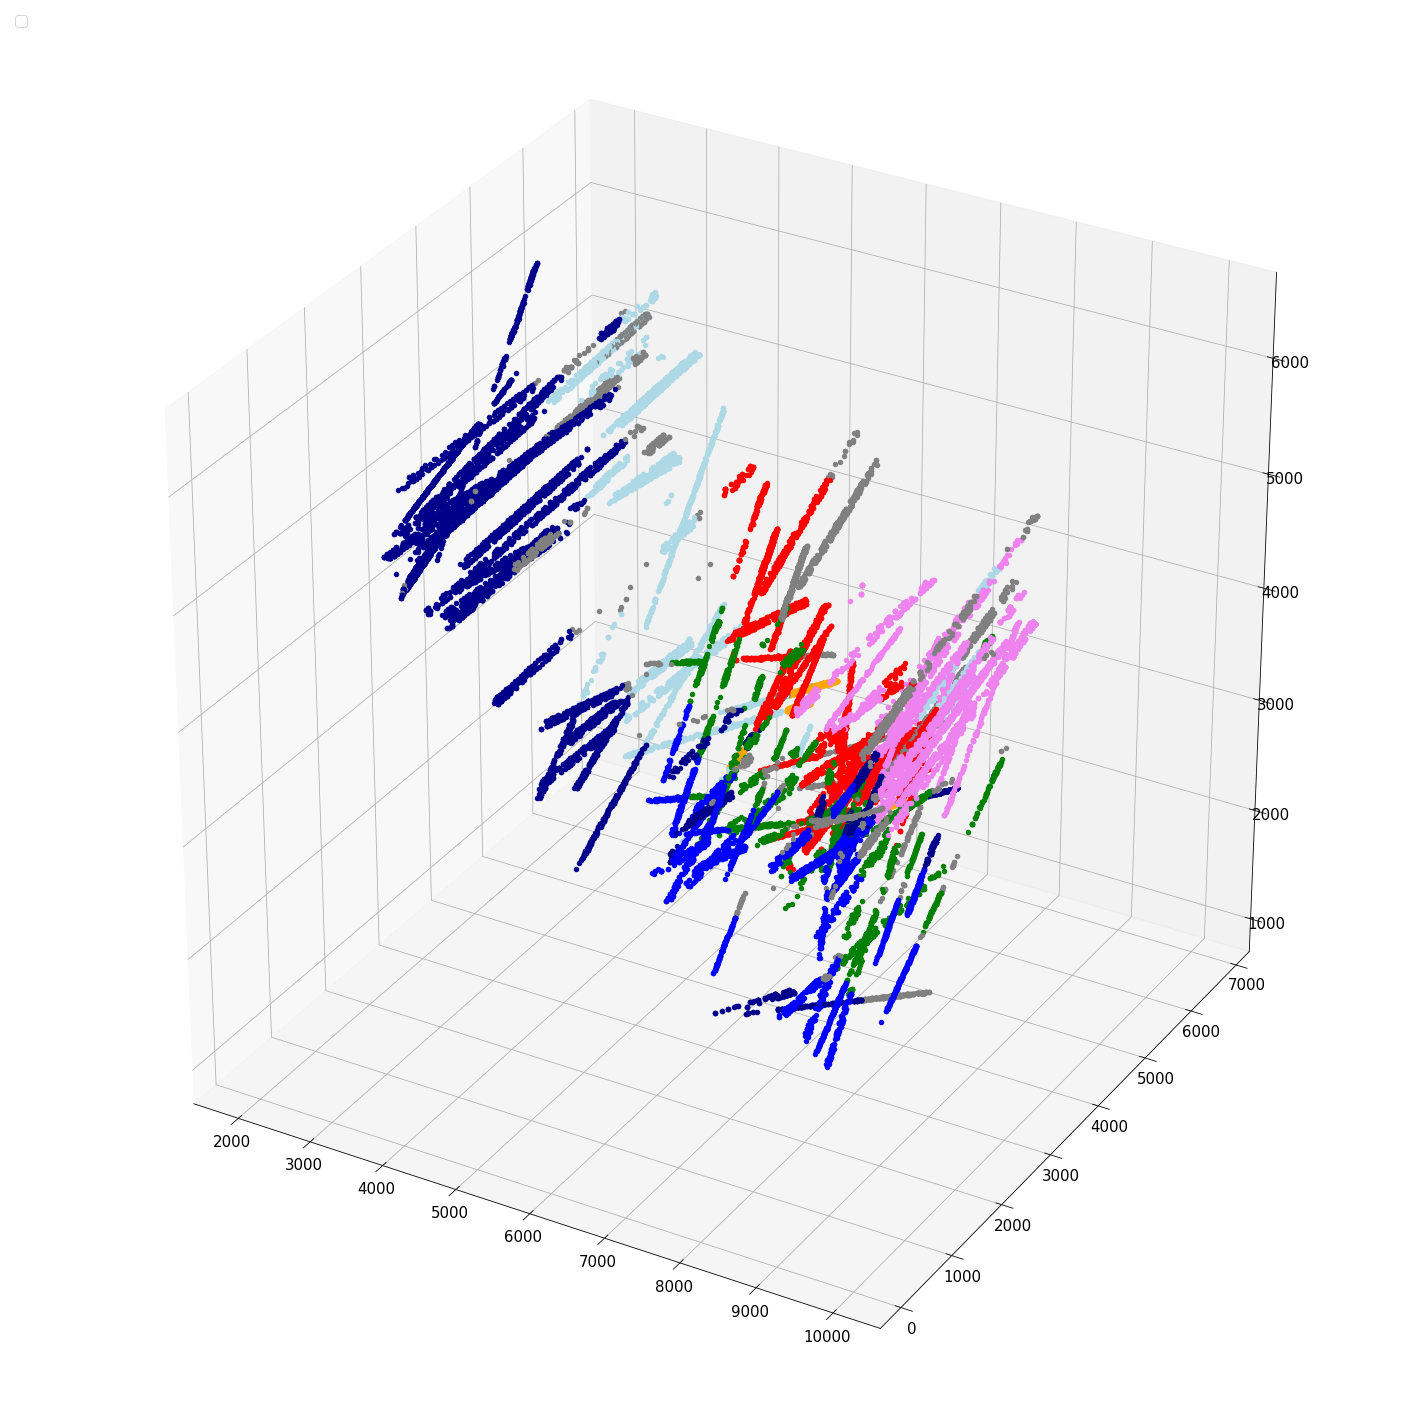

In [195]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
for y,x in alpha.items():
  i=0
  for j in brain_groups:
    if y in j:
      real=i
      break
    i=i+1
  print(i)
  for z in x:
    ax.scatter(z[0],z[1],z[2], color=region_colors[i])
  
plt.legend(loc="upper left")
plt.show()

In [1]:
print(region_colors[1])

NameError: ignored